In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [23]:
# define model
def vehicle(v,t,u,load):
    # inputs
    #  v    = vehicle velocity (m/s)
    #  t    = time (sec)
    #  u    = gas pedal position (-50% to 100%)
    #  load = passenger load + cargo (kg)
    Cd = 0.24    # drag coefficient
    rho = 1.225  # air density (kg/m^3)
    A = 5.0      # cross-sectional area (m^2)
    Fp = 30      # thrust parameter (N/%pedal)
    m = 500      # vehicle mass (kg)
    # calculate derivative of the velocity
    dv_dt = (1.0/(m+load)) * (Fp*u - 0.5*rho*Cd*A*v**2)
    return dv_dt

In [30]:
tf = 300.0                 # final time for simulation
nsteps = 301               # number of time steps
delta_t = tf/(nsteps-1)   # how long is each time step?
ts = np.linspace(0,tf,nsteps) # linearly spaced time vector

# simulate step test operation
step = np.zeros(nsteps) # u = valve % open
step[11:] = 20.0       # step up pedal position
# passenger(s) + cargo load
load = 200.0 # kg
# velocity initial condition
v0 = 0.0
# for storing the results
vs = np.zeros(nsteps)

ubias = 0.0
Kc = 1.0/1.2*5.0
tauI = 30.0
sum_int = 0.0
es = np.zeros(nsteps)
ies = np.zeros(nsteps)
sp_stores = np.zeros(nsteps)

sp = 25.0

In [31]:
# simulate with ODEINT
# model doesn't depend on time hence no [ts[i],ts[i+1]] in odeint
for i in range(nsteps-1):
    # changes in set point
    if i == 50:
        sp = 0.0
    if i == 100:
        sp = 15.0
    if i == 150:
        sp = 20.0
    if i == 200:
        sp = 10.0
        
    sp_stores[i+1] = sp
    error = sp - v0
    es[i+1] = error
    sum_int = sum_int + error*delta_t
    u = ubias + Kc*error + Kc/tauI*sum_int
    
    # clip inputs to -50% to 100%
    if u >= 100.0:
        u = 100.0
        # Anti-reset wind-up for integral part
        sum_int = sum_int - error*delta_t
    if u <= -50.0:
        u = -50.0
        # Anti-reset wind-up for integral part
        sum_int = sum_int - error*delta_t
    step[i+1] = u
    v = odeint(vehicle,v0,[0,delta_t],args=(u,load))
    v0 = v[-1]   # take the last value
    vs[i+1] = v0 # store the velocity for plotting

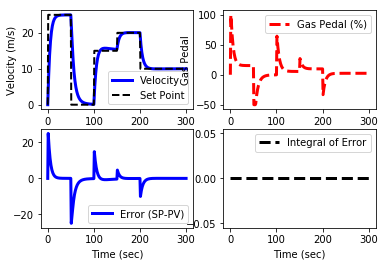

In [32]:
# plot results
plt.figure()
plt.subplot(2,2,1)
plt.plot(ts,vs,'b-',linewidth=3)
plt.plot(ts,sp_stores,'k--',linewidth=2)
plt.ylabel('Velocity (m/s)')
plt.legend(['Velocity','Set Point'],loc='best')
plt.subplot(2,2,2)
plt.plot(ts,step,'r--',linewidth=3)
plt.ylabel('Gas Pedal')    
plt.legend(['Gas Pedal (%)'])
plt.subplot(2,2,3)
plt.plot(ts,es,'b-',linewidth=3)
plt.xlabel('Time (sec)')
plt.legend(['Error (SP-PV)'])
plt.subplot(2,2,4)
plt.plot(ts,ies,'k--',linewidth=3)
plt.xlabel('Time (sec)')
plt.legend(['Integral of Error'])
plt.show()